In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install wandb -q

     |████████████████████████████████| 1.8MB 11.1MB/s 
     |████████████████████████████████| 163kB 43.7MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 133kB 40.6MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# Turning off tensorflow warning message (not recommended)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as kb
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import Callback
import random
import pdb
import wandb
from os.path import join, isfile
from os import listdir

In [ ]:
print(tf.__version__)

1.15.2


In [6]:
wandb.login()

wandb: Currently logged in as: awesomericky (use `wandb login --relogin` to force relogin)


True

In [7]:
device_name = tf.test.gpu_device_name()
print('Found GPU at {}'.format(device_name))

Found GPU at /device:GPU:0


In [8]:
"""
utils.py
"""

def read_script_files(script_dir_path):
    script_files = [f for f in listdir(script_dir_path) if isfile(join(script_dir_path, f))]
    script_files.sort()
    return script_files

def data_shuffle(relative_data_directory_path):
    data_files = read_script_files(relative_data_directory_path)
    random.shuffle(data_files)
    return data_files

In [9]:
"""
processed_data_loader.py
"""

def load_single_npz_data(relative_data_directory_path, file_name):
    file_path = join(relative_data_directory_path, file_name)
    data = np.load(file=file_path)
    return data

In [10]:
"""
TCN_and_decoder.py
"""

class ResidualBlock(tf.keras.Model):
    def __init__(self, dilation_rate, num_filters, kernel_size, padding, 
                        dropout_rate, seed, training_state):
        super(ResidualBlock, self).__init__()
        init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=1)
        layers = tf.keras.layers
        assert padding in ['causal', 'same']

        self.training_state = training_state

        # Block1
        self.conv1 = layers.Conv1D(filters=num_filters, kernel_size=kernel_size, data_format='channels_last',
                                    dilation_rate=dilation_rate, padding=padding, kernel_initializer=init)
        self.batch1 = layers.BatchNormalization(axis=1, trainable=True)
        self.ac1 = layers.LeakyReLU(alpha=0.2)
        self.drop1 = layers.Dropout(rate=dropout_rate)

        # Block2
        self.conv2 = layers.Conv1D(filters=num_filters, kernel_size=kernel_size, data_format='channels_last',
                                    dilation_rate=dilation_rate, padding=padding, kernel_initializer=init)
        self.batch2 = layers.BatchNormalization(axis=1, trainable=True)
        self.ac2 = layers.LeakyReLU(alpha=0.2)
        self.drop2 = layers.Dropout(rate=dropout_rate)

        self.downsample = layers.Conv1D(filters=num_filters, kernel_size=1,
                                        padding='same', kernel_initializer=init)
        self.ac3 = layers.LeakyReLU(alpha=0.2)
    
    def call(self, x):
        # Block1
        prev_x = x
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.ac1(x)
        x = self.drop1(x) if self.training_state else x

        # Block2
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.ac2(x)
        x = self.drop2(x) if self.training_state else x

        # Match dimention
        if prev_x.shape[-1] != x.shape[-1]:
            prev_x = self.downsample(prev_x)
        assert prev_x.shape[1:] == x.shape[1:]

        # skip connection
        return self.ac3(prev_x + x)

# # Test
# x = tf.convert_to_tensor(np.random.random((100, 80, 303)))   # batch, dim, seq_len
# model = ResidualBlock(dilation_rate=1, num_filters=80, kernel_size=3, padding='causal', dropout_rate=0.2, seed=1, training_state=True)
# y = model(x)
# print(y.shape)
# model.summary()

# # Check model
# x = tf.keras.Input(batch_shape=(10, 80, 303))
# model = ResidualBlock(dilation_rate=1, num_filters=80, kernel_size=3, padding='causal', dropout_rate=0.2, seed=1, training_state=True)
# model.build((10, 80, 303))
# model = tf.keras.Model(inputs=x, outputs=model.call(x))
# plot_model(model, to_file='residual_block.png')


class TemporalBlock(tf.keras.Model):
    def __init__(self, num_channels, kernel_size, dropout_rate, seed, training_state):
        # num_channels is a list contains hidden channel numbers of Conv1D
        # len(num_channels) is number of convolutional layers in one Temporal Block
        super(TemporalBlock, self).__init__()
        assert isinstance(num_channels, list)

        self.num_levels = len(num_channels)
        self.resi_blocks = [0]*self.num_levels
        for i in range(self.num_levels):
            dilation_rate = 2**i
            self.resi_blocks[i] = ResidualBlock(dilation_rate, num_channels[i], kernel_size, padding='causal',
                            dropout_rate=dropout_rate, seed=seed, training_state=training_state)
    
    def call(self, x):
        for i in range(self.num_levels):
            x = self.resi_blocks[i](x)
        return x

# # Test
# x = tf.convert_to_tensor(np.random.random((100, 80, 303)))   # batch, dim, seq_len
# model = TemporalBlock(num_channels=[80, 80, 80], kernel_size=3, dropout_rate=0.2, seed=1, training_state=True)
# y = model(x)
# print(y.shape)
# model.summary()

# # Check model
# x = tf.keras.Input(batch_shape=(10, 80, 303))
# model = TemporalBlock(num_channels=[80, 80, 80, 80, 80, 80], kernel_size=3, dropout_rate=0.2, seed=1, training_state=True)
# model.build((10, 80, 303))
# model = tf.keras.Model(inputs=x, outputs=model.call(x))
# plot_model(model, to_file='temporal_block.png')

class TempConvnet(tf.keras.Model):
    def __init__(self, num_stacks, num_channels, kernel_size, dropout_rate, return_type, seed, training_state):
        # num_stacks number of Temporal Blocks in Temporal convolutional network
        super(TempConvnet, self).__init__()
        assert isinstance(num_stacks, int)
        assert isinstance(num_channels, list)
        assert return_type in ['whole', 'end']

        self.num_stacks = num_stacks
        self.temp_blocks = [0]*self.num_stacks
        self.return_type = return_type
        for i in range(num_stacks):
            self.temp_blocks[i] = TemporalBlock(num_channels, kernel_size=kernel_size, dropout_rate=dropout_rate, seed=seed, training_state=training_state)
    
    def call(self, x):
        for i in range(self.num_stacks):
            x = self.temp_blocks[i](x)
        
        if self.return_type == 'whole':
            return x
        elif self.return_type == 'end':
            return x[:, -1, :]

# # Test
# x = tf.convert_to_tensor(np.random.random((100, 303, 80)))   # batch, dim, seq_len
# model = TempConvnet(num_stacks=3, num_channels=[80, 80, 80], kernel_size=3, dropout_rate=0.2, return_type='end', seed=1, training_state=True)
# y = model(x)
# print(y.shape)
# model.summary()

# # Check model
# x = tf.keras.Input(batch_shape=(10, 80, 303))
# model = TempConvnet(num_stacks=3, num_channels=[80, 80, 80, 80, 80, 80], kernel_size=3, dropout_rate=0.2, return_type='end', seed=1, training_state=True)
# model.build((10, 80, 303))
# model = tf.keras.Model(inputs=x, outputs=model.call(x))
# plot_model(model, to_file='temporal_CNN.png')

class TempConvnet_Decoder(tf.keras.Model):
    def __init__(self, decoder_type, num_levels, num_channels, kernel_size, padding, upsample_size, dropout_rate, output_shape, seed, training_state):
        super(TempConvnet_Decoder, self).__init__()
        assert isinstance(num_channels, int)
        assert isinstance(kernel_size, list)
        assert isinstance(upsample_size, dict)
        assert padding in ['causal', 'same']
        assert decoder_type in ['linguistic', 'acoustic']
        assert num_levels == upsample_size[2] + upsample_size[3] + upsample_size[0]

        init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=1)
        layers = tf.keras.layers

        self.training_state = training_state

        self.size2_upsample_num = upsample_size[2]
        self.size3_upsample_num = upsample_size[3]
        self.reshape_conv_num = 1
        self.num_levels = num_levels
        self.final_kernel_size = kernel_size[1]
        self.output_len = output_shape[-1]  ## ex) (num_batch, num_time_steps, dictionary_length)

        self.upsample_blocks = [0]*(num_levels-1)
        self.conv_blocks = [0]*(num_levels-1)
        self.batchnorm_blocks = [0]*(num_levels-1)
        self.ac_blocks = [0]*(num_levels-1)
        self.drop_blocks = [0]*(num_levels-1)

        for i in range(num_levels-self.size3_upsample_num-self.reshape_conv_num):
            self.upsample_blocks[i] = layers.UpSampling1D(size=2)
            self.conv_blocks[i] = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                                    padding=padding, kernel_initializer=init)
            self.batchnorm_blocks[i] = layers.BatchNormalization(axis=-1, trainable=True)
            self.ac_blocks[i] = layers.ReLU() if decoder_type == 'linguistic' else layers.LeakyReLU(alpha=0.2)
            self.drop_blocks[i] = layers.Dropout(rate=dropout_rate)
        for i in range(num_levels-self.size3_upsample_num-self.reshape_conv_num, num_levels-self.reshape_conv_num):
            self.upsample_blocks[i] = layers.UpSampling1D(size=3)
            self.conv_blocks[i] = layers.Conv1D(filters=num_channels, kernel_size=kernel_size[0], data_format='channels_last',
                                                    padding=padding, kernel_initializer=init)
            self.batchnorm_blocks[i] = layers.BatchNormalization(axis=-1, trainable=True)
            self.ac_blocks[i] = layers.Activation('tanh') if decoder_type == 'linguistic' else layers.LeakyReLU(alpha=0.2)
            self.drop_blocks[i] = layers.Dropout(rate=dropout_rate)
        self.final_conv_block = layers.Conv1D(filters=num_channels, kernel_size=self.final_kernel_size, data_format='channels_last',
                                                    padding='valid', kernel_initializer=init)
        self.final_ac_block = layers.Softmax(axis=-1) if decoder_type == 'linguistic' else layers.LeakyReLU(alpha=0.2)
        self.final_reshape_block = layers.Permute((2, 1))
    
    def call(self, x):
        for i in range(self.num_levels-1):
            x = self.upsample_blocks[i](x)
            x = self.conv_blocks[i](x)
            x = self.batchnorm_blocks[i](x)
            x = self.ac_blocks[i](x)
            x = self.drop_blocks[i](x) if self.training_state else x
        len_padding = (self.output_len - (x.shape[1] - self.final_kernel_size) - 1)//2
        x = tf.keras.layers.ZeroPadding1D(padding=(len_padding, len_padding))(x)
        x = self.final_conv_block(x)
        x = self.final_ac_block(x)
        y = self.final_reshape_block(x)
        return y

# # Test
# x = tf.convert_to_tensor(np.random.random((100, 1, 80)))   # batch, seq_len, dim
# model = TempConvnet_Decoder(decoder_type='linguistic', num_levels=8, num_channels=42, kernel_size=[2, 2], 
#                             padding='causal', upsample_size={2: 5, 3: 2, 0:1}, dropout_rate=0.2, output_shape=(100, 42, 303), seed=1, training_state=True)
# y = model(x, True)
# print(y.shape)
# model.summary()

# # Check model
# # linguistic decoder
# x = tf.keras.Input(batch_shape=(10, 1, 80)) # batch_size: 10
# model = TempConvnet_Decoder(decoder_type='linguistic', num_levels=8, num_channels=42, kernel_size=[2, 2], 
#                             padding='causal', upsample_size={2: 5, 3: 2, 0:1}, dropout_rate=0.2, output_shape=(None, 42, 303), seed=1, training_state=True)
# model.build((10, 1, 80))
# model = tf.keras.Model(inputs=x, outputs=model.call(x))
# plot_model(model, to_file='linguistic_decoder.png')

# # acoustic decoder
# x = tf.keras.Input(batch_shape=(10, 1, 80)) # batch_size: 10
# model = TempConvnet_Decoder(decoder_type='acoustic', num_levels=8, num_channels=80, kernel_size=[2, 2], 
#                             padding='causal', upsample_size={2: 5, 3: 2, 0:1}, dropout_rate=0.2, output_shape=(None, 80, 303), seed=1, training_state=True)
# model.build((10, 1, 80))
# model = tf.keras.Model(inputs=x, outputs=model.call(x))
# plot_model(model, to_file='acoustic_decoder.png')

In [11]:
"""
sentenceEM.py
"""

class sentenceEM(tf.keras.Model):
    def __init__(self, encoder_args, linguistic_decoder_args, acoustic_decoder_args, input_shapes, seed, training_state):
        """
        1) encoder_args: 
        num_stacks, num_channels, kernel_size, dropout_rate, return_type, seed
        2) linguistic_decoder_args:
        decoder_type, num_levels, num_channels, kernel_size, padding, upsample_size, dropout_rate, output_shape, seed, training_state
        3) acoustic_decoder_args:
        decoder_type, num_levels, num_channels, kernel_size, padding, upsample_size, dropout_rate, output_shape, seed, training_state
        """
        super(sentenceEM, self).__init__()
        self.input_shapes = input_shapes
        self.input_reshape_block = layers.Permute((2, 1))
        self.encoder = TempConvnet(num_stacks=encoder_args['num_stacks'], num_channels=encoder_args['num_channels'],
                                        kernel_size=encoder_args['kernel_size'], dropout_rate=encoder_args['dropout_rate'],
                                        return_type=encoder_args['return_type'], seed=seed, training_state=training_state)
        self.linguistic_decoder = TempConvnet_Decoder(decoder_type=linguistic_decoder_args['decoder_type'], num_levels=linguistic_decoder_args['num_levels'],
                                                        num_channels=linguistic_decoder_args['num_channels'], kernel_size=linguistic_decoder_args['kernel_size'],
                                                        padding=linguistic_decoder_args['padding'], upsample_size=linguistic_decoder_args['upsample_size'],
                                                        dropout_rate=linguistic_decoder_args['dropout_rate'], output_shape=linguistic_decoder_args['output_shape'],
                                                        seed=seed, training_state=training_state)
        self.acoustic_decoder = TempConvnet_Decoder(decoder_type=acoustic_decoder_args['decoder_type'], num_levels=acoustic_decoder_args['num_levels'],
                                                        num_channels=acoustic_decoder_args['num_channels'], kernel_size=acoustic_decoder_args['kernel_size'],
                                                        padding=acoustic_decoder_args['padding'], upsample_size=acoustic_decoder_args['upsample_size'],
                                                        dropout_rate=acoustic_decoder_args['dropout_rate'], output_shape=acoustic_decoder_args['output_shape'],
                                                        seed=seed, training_state=training_state)
    
    def call(self, x):
        embedded_outputs = self.input_reshape_block(x)
        embedded_outputs = self.encoder(embedded_outputs)
        embedded_outputs = kb.expand_dims(embedded_outputs, axis=1)
        linguistic_outputs = self.linguistic_decoder(embedded_outputs)
        acoustic_outputs = self.acoustic_decoder(embedded_outputs)
        return linguistic_outputs, acoustic_outputs
    
    def encoder_call(self, x):
        embedded_outputs = self.input_reshape_block(x)
        embedded_outputs = self.encoder(embedded_outputs)
        return embedded_outputs
    
    def decoder_call(self, x):
        embedded_outputs = kb.expand_dims(x, axis=1)
        linguistic_outputs = self.linguistic_decoder(embedded_outputs)
        acoustic_outputs = self.acoustic_decoder(embedded_outputs)
        return linguistic_outputs, acoustic_outputs
    
    def build_seperate_graph(self):
        # Encoder graph
        x = tf.keras.Input(batch_shape=self.input_shapes)
        embedded_outputs = self.encoder_call(x)
        self.embedded_outputs_shape = embedded_outputs.shape
        self.encoder_model = tf.keras.Model(inputs=x, outputs=embedded_outputs)

        # Decoder graph
        embeddings = tf.keras.Input(batch_shape=self.embedded_outputs_shape)
        linguistic_outputs, acoustic_outputs = self.decoder_call(embeddings)
        self.decoder_model = tf.keras.Model(inputs=embeddings, outputs=[linguistic_outputs, acoustic_outputs])
    
    def build_total_graph(self):
        # x = tf.keras.Input(batch_shape=self.input_shapes)
        x = tf.keras.Input(batch_input_shape=self.input_shapes)
        y = self.encoder_model(x)
        l_y, a_y = self.decoder_model(y)
        self.model = tf.keras.Model(inputs=x, outputs=[l_y, a_y])

    # def model_visualize(self):
    #     self.model.summary()
    #     plot_model(self.model, to_file='/home/awesomericky/Lab_intern/Prof_Oh/Code/Speech2Pickup/image/sentenceEM.png')
    
    def encoder_model_compile(self, lr):
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.encoder_model.compile(optimizer=optimizer)

    def model_compile(self, lr, loss_weights):
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.model.compile(optimizer=optimizer, loss=[self.linguistic_loss_function, self.acoustic_loss_function],
                           loss_weights=[loss_weights['linguistic'], loss_weights['acoustic']],
                           metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.MeanSquaredError()])

    def model_train(self, X_train, Y_linguistic_train, Y_acoustic_train, batch_size):
        hist = History()
        self.model.fit(x=X_train, y=[Y_linguistic_train, Y_acoustic_train], batch_size=batch_size, epochs=1, verbose=1, callbacks=[hist], validation_split=0.1)
        return hist.losses, hist.linguistic_losses, hist.acoustic_losses, hist.val_losses, hist.val_linguistic_accuracy, hist.val_acoustic_accuracy
    
    def linguistic_loss_function(self, y_actual, y_predicted):
        epsil = 1e-5
        y_predicted = -kb.log(y_predicted + epsil)
        loss = layers.multiply([y_actual, y_predicted])
        loss = kb.sum(loss, axis=1)
        loss = kb.mean(loss, keepdims=False)
        return loss
    
    def acoustic_loss_function(self, y_actual, y_predicted):
        loss = layers.subtract([y_actual, y_predicted])
        loss = layers.multiply([loss, loss])
        loss = kb.mean(loss, keepdims=False)
        return loss

class History(Callback):
    def on_train_begin(self,logs={}):
        self.losses = []
        self.linguistic_losses = []
        self.acoustic_losses = []
        self.val_losses = []
        self.val_linguistic_accuracy = []
        self.val_acoustic_accuracy = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.linguistic_losses.append(logs.get('model_1_loss'))
        self.acoustic_losses.append(logs.get('model_1_1_loss'))
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.val_linguistic_accuracy.append(logs.get('val_model_1_categorical_accuracy'))
        self.val_acoustic_accuracy.append(logs.get('val_model_1_1_mean_squared_error'))

In [12]:
# Model configure

train_model_number = 5
batch_size = 64; seed = 1; lr = 0.0005; epochs = 100; loss_weights={'linguistic': 1, 'acoustic': 0.005}
n_mels = 40
time_steps = 303
word_dic_size = 43
training_state = True
input_shapes = (None, n_mels, time_steps)
encoder_args = {'num_stacks': 3, 'num_channels':[n_mels for i in range(6)], 'kernel_size':3, 'dropout_rate': 0.2, 'return_type': 'end'}
linguistic_decoder_args = {'decoder_type': 'linguistic', 'num_levels':8, 'num_channels': word_dic_size, 'kernel_size': [2, 2], 'padding': 'causal',
                            'upsample_size': {2: 5, 3: 2, 0:1}, 'dropout_rate': 0.2, 'output_shape': (batch_size, word_dic_size, time_steps)}
acoustic_decoder_args = {'decoder_type': 'acoustic', 'num_levels':8, 'num_channels': n_mels, 'kernel_size': [2, 2], 'padding': 'causal',
                            'upsample_size': {2: 5, 3: 2, 0:1}, 'dropout_rate': 0.2, 'output_shape': (batch_size, n_mels, time_steps)}

with tf.device('/device:GPU:0'):
  sen_em_model = sentenceEM(encoder_args=encoder_args, linguistic_decoder_args=linguistic_decoder_args, acoustic_decoder_args=acoustic_decoder_args,
                            input_shapes=input_shapes, seed=seed, training_state=training_state)
  sen_em_model.build_seperate_graph()
  sen_em_model.build_total_graph()
  sen_em_model.model_compile(lr=lr, loss_weights=loss_weights)
# sen_em_model.model_visualize()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# Read data files

relative_data_directory_path = '/content/drive/MyDrive/Speech2Pickup/data_v2.2_single_channel'

data_files = listdir(relative_data_directory_path)
indexs = []
for a_i in data_files:
  index = a_i.split('.')[0].split('_')[-1]
  indexs.append(int(index))
indexs.sort()
print(len(indexs))

In [ ]:
# Train

wandb_config = {'batch_size':batch_size,
                'learning_rate': lr,
                'loss_weight (linguistic, acoustic)': (loss_weights['linguistic'], loss_weights['acoustic']),
                'channel_type': 'single',
                'n_mels': n_mels,
                'seed': seed,
                'date': '2020-11-28',
                'train_model_number': train_model_number}
wandb.init(project='Speech2Pickup', name='sentenceEM', config=wandb_config)
model_save_freq = 1
total_model_file_path = '/content/drive/MyDrive/Speech2Pickup/sentenceEM_model/' + str(train_model_number) + '/total_model/sentenceEM_total_model'
encoder_model_file_path = '/content/drive/MyDrive/Speech2Pickup/sentenceEM_model/' + str(train_model_number) + '/encoder_model/sentenceEM_encoder_model'
model_configuration_file = '/content/drive/MyDrive/Speech2Pickup/sentenceEM_model/' + str(train_model_number) + '/model_config.txt'

# Write model configuration in .txt file
with open(model_configuration_file, 'w') as f:
  f.write(str(wandb_config))

for i in range(epochs):
    try:
        print('='*20)
        print('Epoch: {}'.format(i+1))

        # Prepare training
        one_shot_load_num = 50
        start = 0
        end = start + batch_size*one_shot_load_num
        epoch_loss = []
        extra_train_state = False
        # if i == 0:
        #     data_files = data_shuffle(relative_data_directory_path)
        # else:
        #     random.shuffle(data_files)
        random.shuffle(data_files)
          
        if len(data_files) % (batch_size*one_shot_load_num) != 0:
            extra_train_state = True
            print('extra train needed')
        
        # Train
        while end <= len(data_files):
            print('Processing {}/{}'.format(end//(batch_size*one_shot_load_num), len(data_files)//(batch_size*one_shot_load_num))) if extra_train_state == False \
            else print('Processing {}/{}'.format(end//(batch_size*one_shot_load_num), (len(data_files)//(batch_size*one_shot_load_num))+1))
            batch_data_files = data_files[start:end]
            acoustic_train_batch = []
            linguistic_train_batch = []
            for ii in range(batch_size*one_shot_load_num):
                if (ii+1) % batch_size == 0:
                  print('Loading data {}/{}'.format(ii+1, batch_size*one_shot_load_num))
                data = load_single_npz_data(relative_data_directory_path=relative_data_directory_path, file_name=batch_data_files[ii])
                acoustic_train_batch.append(data['arr_0'])
                linguistic_train_batch.append(data['arr_1'])
            acoustic_train_batch = np.array(acoustic_train_batch)
            linguistic_train_batch = np.array(linguistic_train_batch)
            with tf.device('/device:GPU:0'):
              temp_loss, temp_linguistic_loss, temp_acoustic_loss, temp_val_loss, temp_val_linguistic_accuracy, temp_val_acoustic_accuracy = sen_em_model.model_train(X_train=acoustic_train_batch, Y_linguistic_train=linguistic_train_batch,
                                                                                                                                                                      Y_acoustic_train=acoustic_train_batch, batch_size=batch_size)
              
              for iii in range(len(temp_loss)):
                wandb.log({'temp_loss': temp_loss[iii]})
                wandb.log({'temp_linguistic_loss': temp_linguistic_loss[iii]})
                wandb.log({'temp_acoustic_loss': temp_acoustic_loss[iii]})
              for iii in range(len(temp_val_loss)):
                wandb.log({'temp_val_loss': temp_val_loss[iii]})
                wandb.log({'temp_val_linguistic_accuracy': temp_val_linguistic_accuracy[iii]})
                wandb.log({'temp_val_acoustic_accuracy': temp_val_acoustic_accuracy[iii]})
              epoch_loss.extend(temp_loss)
            start = end
            end = start + batch_size*one_shot_load_num
            
        if extra_train_state:
            print('Processing {}/{}'.format((len(data_files)//(batch_size*one_shot_load_num))+1, (len(data_files)//(batch_size*one_shot_load_num))+1))
            batch_data_files = data_files[start:]
            acoustic_train_batch = []
            linguistic_train_batch = []
            for ii in range(len(batch_data_files)):
                if (ii+1) % batch_size == 0:
                  print('Loading data {}/{}'.format(ii+1, batch_size*one_shot_load_num))
                data = load_single_npz_data(relative_data_directory_path=relative_data_directory_path, file_name=batch_data_files[ii])
                acoustic_train_batch.append(data['arr_0'])
                linguistic_train_batch.append(data['arr_1'])
            acoustic_train_batch = np.array(acoustic_train_batch)
            linguistic_train_batch = np.array(linguistic_train_batch)
            with tf.device('/device:GPU:0'):
              temp_loss, temp_linguistic_loss, temp_acoustic_loss, temp_val_loss, temp_val_linguistic_accuracy, temp_val_acoustic_accuracy = sen_em_model.model_train(X_train=acoustic_train_batch, Y_linguistic_train=linguistic_train_batch,
                                                                                                                                                                      Y_acoustic_train=acoustic_train_batch, batch_size=batch_size)
              for iii in range(len(temp_loss)):
                wandb.log({'temp_loss': temp_loss[iii]})
                wandb.log({'temp_linguistic_loss': temp_linguistic_loss[iii]})
                wandb.log({'temp_acoustic_loss': temp_acoustic_loss[iii]})
              for iii in range(len(temp_val_loss)):
                wandb.log({'temp_val_loss': temp_val_loss[iii]})
                wandb.log({'temp_val_linguistic_accuracy': temp_val_linguistic_accuracy[iii]})
                wandb.log({'temp_val_acoustic_accuracy': temp_val_acoustic_accuracy[iii]})
              epoch_loss.extend(temp_loss)

        epoch_loss = np.mean(np.array(epoch_loss))
        wandb.log({'epoch_loss': epoch_loss})

        # Model save
        if (i+1) % model_save_freq == 0:
          print('Finished training {} epochs'.format(i+1))
          sen_em_model.model.save_weights(filepath=total_model_file_path, overwrite=True)
          sen_em_model.encoder_model.save_weights(filepath=encoder_model_file_path, overwrite=True)
          print('Model saving complete!')
    except KeyboardInterrupt:
        pass

Epoch: 2
extra train needed
Processing 1/13
Loading data 64/3200
Loading data 128/3200
Loading data 192/3200
Loading data 256/3200
Epoch: 3
extra train needed
Processing 1/13
Epoch: 4
extra train needed
Processing 1/13


Exception: ignored

In [ ]:
# Erase model from memory

tf.keras.backend.clear_session()
del sen_em_model

In [ ]:
# Load model (model compiling should be done first)
sen_em_model.model.load_weights('/content/drive/MyDrive/Speech2Pickup/sentenceEM_model/total_model/sentenceEM_total_model')

In [ ]:
"""
utils.py
"""

def read_script_files(script_dir_path):
    script_files = [f for f in listdir(script_dir_path) if isfile(join(script_dir_path, f))]
    script_files.sort()
    return script_files

def read_script_file_data(script_dir_path, script_file):
    curr_file = open(join(script_dir_path, script_file), 'r')
    curr_file_lines = curr_file.readlines()
    for i in range(len(curr_file_lines)):
        words = curr_file_lines[i].split()[2: ]
        curr_file_lines[i] = ' '.join(words)
    return curr_file_lines

In [ ]:
"""
process_data.py
"""

def make_word_dictionary(relative_script_directory_path):
    # Check whole word candidates
    script_files = read_script_files(relative_script_directory_path)
    total_words = set()
    num = 0
    for script_file in script_files:
        num += 1
        print('Processing {}/{}'.format(num, len(script_files)))
        curr_file_lines = read_script_file_data(relative_script_directory_path, script_file)
        for curr_file_line in curr_file_lines:
            total_words.update(set(curr_file_line.split()))
    total_words = list(total_words)
    total_words.append("")  # blank
    total_words.append("OOV")  # Out of vocabulary
    total_words.sort()

    # One-hot encoding
    word_dictionary = dict()
    word_dictionary_size = len(total_words)
    for i in range(word_dictionary_size):
        one_hot = np.zeros(word_dictionary_size)
        one_hot[i] = 1
        word_dictionary[total_words[i]] = one_hot
    # print(word_dictionary)
    return word_dictionary, word_dictionary_size

In [ ]:
# Set word dictionary to check output of model later

relative_script_directory_path = './drive/MyDrive/Speech2Pickup/train_script'
word_dic, word_dic_size = make_word_dictionary(relative_script_directory_path)

In [ ]:
# Show corresponding sentence
sentence = []
new_sentence = []
mul_result = np.matmul(data_list['arr_1'].T, word_label_list)
word_indexs = np.argwhere(mul_result==1)
word_indexs = word_indexs[:, 1]
for word_index in word_indexs:
    sentence.append(word_list[word_index])
for word in sentence:
    if word not in new_sentence:
        new_sentence.append(word)
new_sentence = ' '.join(new_sentence)
print(new_sentence)

True: pick up the upper purple block 
Predict: pick up the lower left green red green block  pick


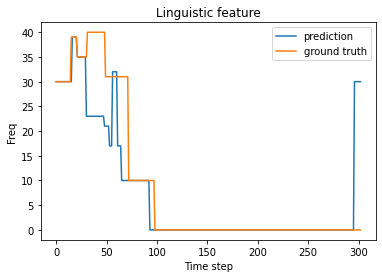

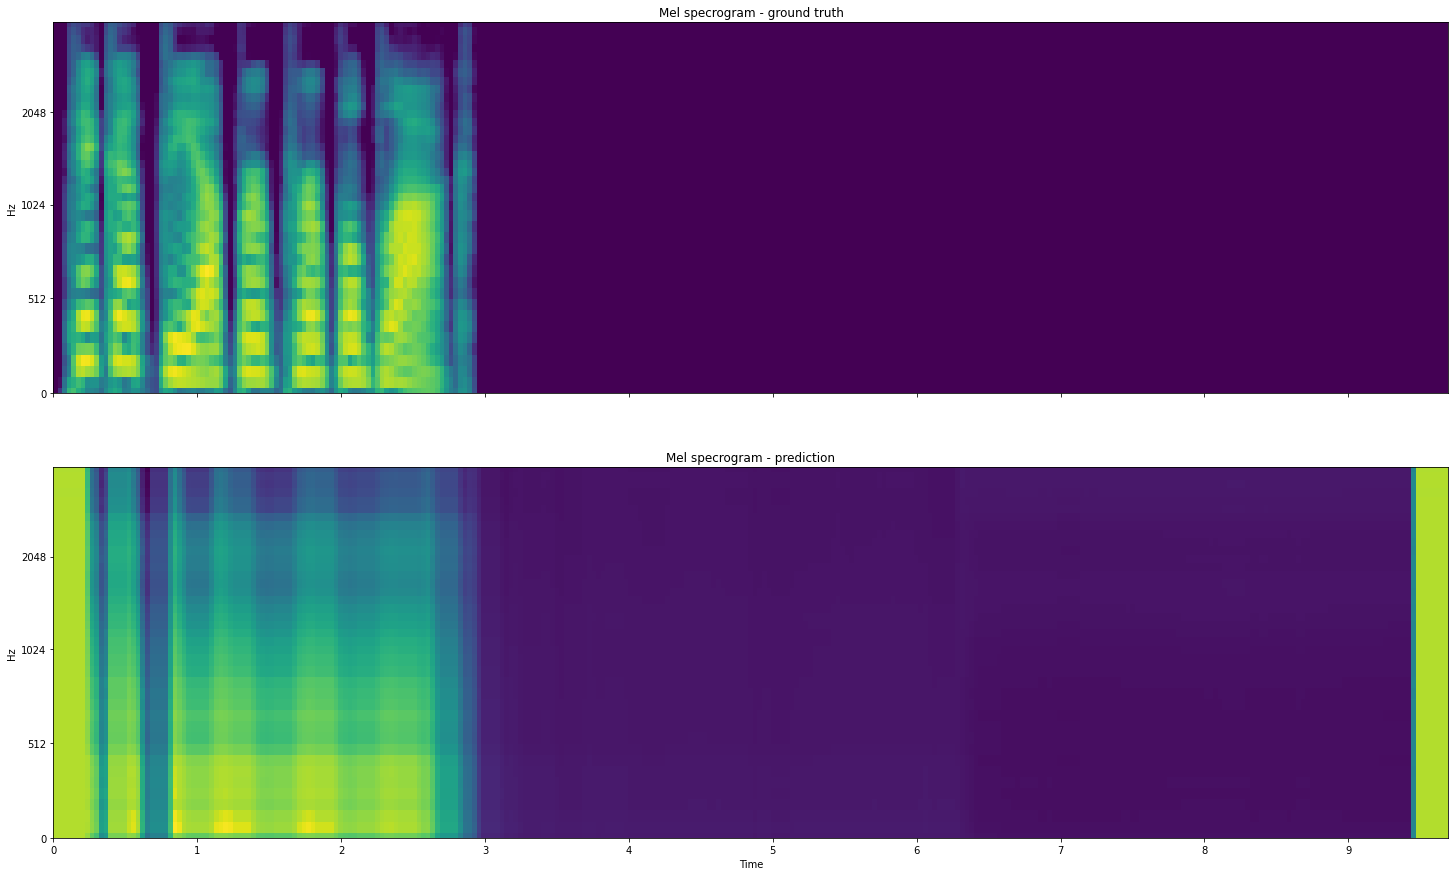

In [ ]:
# Check output of loaded model

import matplotlib.pyplot as plt
import librosa.display

relative_data_directory_path = '/content/drive/MyDrive/Speech2Pickup/data_v2.2_single_channel'
file_name = 'senEM_preprocessed_40009.npz'
data = load_single_npz_data(relative_data_directory_path=relative_data_directory_path, file_name=file_name)
acoustic_train_batch = [data['arr_0']]
linguistic_train_batch = [data['arr_1']]
acoustic_train_batch = np.array(acoustic_train_batch, dtype=np.float32)
linguistic_train_batch = np.array(linguistic_train_batch, dtype=np.float32)
l_out, a_out = sen_em_model.call(acoustic_train_batch)

l_out = np.squeeze(kb.eval(l_out))
a_out = np.squeeze(kb.eval(a_out))
l_true = np.squeeze(linguistic_train_batch)
a_true = np.squeeze(acoustic_train_batch)

l_out = np.argmax(l_out, axis=0)
l_true = np.argmax(l_true, axis=0)

true_sentence = []
predicted_sentence = []
word_dic_keys = list(word_dic.keys())
n = 0
for i in l_true:
  if n==0:
    true_sentence.append(word_dic_keys[i])
  elif true_sentence[-1] != word_dic_keys[i]:
    true_sentence.append(word_dic_keys[i])
  n += 1
n = 0
for i in l_out:
  if n==0:
    predicted_sentence.append(word_dic_keys[i])
  elif predicted_sentence[-1] != word_dic_keys[i]:
    predicted_sentence.append(word_dic_keys[i])
  n += 1
true_sentence = ' '.join(true_sentence)
predicted_sentence = ' '.join(predicted_sentence)
print('True: {}'.format(true_sentence))
print('Predict: {}'.format(predicted_sentence))

fig, ax = plt.subplots(1)
ax.plot(l_out, label='prediction')
ax.plot(l_true, label='ground truth')
ax.set_title('Linguistic feature')
ax.set_xlabel('Time step')
ax.set_ylabel('Freq')
plt.legend()
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(25,15))
img = librosa.display.specshow(data=a_true, sr=8000, hop_length=256,  x_axis='time',
                            y_axis='mel', cmap='viridis', fmax=4000, ax=ax[0])
ax[0].set(title='Mel specrogram - ground truth')
ax[0].label_outer()

img = librosa.display.specshow(data=a_out, sr=8000, hop_length=256,  x_axis='time',
                            y_axis='mel', cmap='viridis', fmax=4000, ax=ax[1])
ax[1].set(title='Mel specrogram - prediction')
ax[1].label_outer()

In [ ]:
img

In [ ]:
# Test and save for jointly training 'Speech2Pickup' (Debugging)

sen_em_model.model.save_weights(filepath='/content/drive/MyDrive/Speech2Pickup/sentenceEM_model/total_model/sentenceEM_total_model', overwrite=True)
sen_em_model.encoder_model.save_weights(filepath='/content/drive/MyDrive/Speech2Pickup/sentenceEM_model/encoder_model/sentenceEM_encoder_model', overwrite=True)
print('Model saving complete!')

Model saving complete!


In [ ]:
# Compare sorting time

import time
ts = time.time()
random.shuffle(data_files)
te = time.time()
print('String sort: {}'.format(te-ts))
print(data_files)
# ts = time.time()
# random.shuffle(indexs)
# te = time.time()
# print('Int sort: {}'.format(te-ts))

In [ ]:
# Test (Debugging)

data = load_single_npz_data(relative_data_directory_path='/content/drive/MyDrive/Speech2Pickup/data_v2.2', file_name='senEM_preprocessed_100.npz')
data1 = data['arr_0']
data1 = np.float32(data1)
data1 = kb.expand_dims(data1, axis=0)
with tf.device('/device:GPU:0'):
  l_y, a_y = sen_em_model(data1)
print(kb.eval(a_y)[0,:,180])
print('='*20)
print(kb.eval(l_y)[0,:,180])
print(len(kb.eval(l_y)[0,:,180]))
print('='*20)
print(np.sum(kb.eval(l_y)[0,:,180]))
print(np.sum(kb.eval(l_y)[0,:,300]))

In [ ]:
# Test (Debugging)

x = tf.convert_to_tensor(np.random.random((batch_size, 80, 303)), dtype=np.float32)   # batch, dim, seq_len
l_y, a_y = sen_em_model(x)
print('='*20)
print(kb.eval(l_y)[0,:,0])
print(len(kb.eval(l_y)[0,:,0]))
print('='*20)
print(np.sum(kb.eval(l_y)[0,:,0]))
print(np.sum(kb.eval(l_y)[0,:,100]))